# Single-point, semi-honest case

In this scenario, Alice and Bob are both assumed to be semi-honest, meaning that they will follow the protocol as specified, but they may try to learn more about the other party's input by analyzing the messages they receive. The goal is to compute the valuation of Bob's data point $x$, defined as the negative loss of the datapoint on Alice's model $M$.


## Part 0: The setup


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


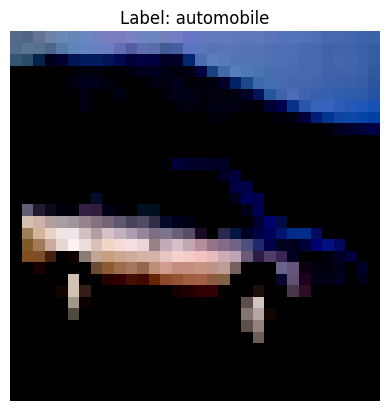

In [ ]:
#First, we define Alice's model M. We assume a simple CNN model.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt

class LeNet(nn.Sequential):
    """
    Adaptation of LeNet that uses ReLU activations
    """

    # network architecture:
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = LeNet()

#Next, we define the data loader for CIFAR-10 dataset.
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True,transform=transform)
data, lbl  = trainset[4]
classes = trainset.classes  # ['airplane', 'automobile', 'bird', ..., 'truck']
class_name = classes[lbl]

# Since 'image' is a Torch tensor of shape (C, H, W),
# we need to permute the axes to (H, W, C) for display.
plt.imshow(data.permute(1, 2, 0))

# Add the class name as the title
plt.title(f"Label: {class_name}")
plt.axis('off')  # Hide axis ticks
plt.show()

#The variable model is Alice's model M, the variable data and lbl is Bob's contribution (x,y).

## Part 1: Model Inference

Given that both parties are semi-honest, we can utilize the library CrypTen